# Explore data

Kaggle page:
* https://www.kaggle.com/c/pubg-finish-placement-prediction

#### Problem description
In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

### Data
1. train.csv - set for model training and evaluation
1. test.csv - set for testing model predictions

#### Data dictionary
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
* groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from scipy.stats.distributions import uniform

# read data

In [2]:
trainingDataPath = "D:/data/kaggle/PUBG/train.csv"
scoringDataPath = "D:/data/kaggle/PUBG/test.csv"

In [3]:
scoringData = pd.read_csv(scoringDataPath)

In [4]:
scoringData.shape

(1867913, 25)

In [5]:
scoringData.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,47734,1659463,47734,0,0,100.0,1,0,0,59,...,45,0,0.0,0,0.0,1,0,421.50,7,1500
1,47735,1659508,47735,0,1,400.0,2,0,3,9,...,47,1,0.0,0,0.0,0,0,655.80,4,1526
2,47736,1659555,47736,0,0,0.0,0,0,0,72,...,28,0,0.0,0,0.0,0,0,74.58,1,1475
3,47737,1659621,47737,0,0,68.6,0,0,0,68,...,92,0,0.0,0,0.0,0,0,167.20,2,1464
4,47738,1659675,47738,0,1,370.5,3,0,1,45,...,26,0,0.0,0,0.0,0,0,146.70,3,1505


In [6]:
trainingData = pd.read_csv(trainingDataPath)
trainingData.shape

(4357336, 26)

In [7]:
trainingData.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0,0,0,640.80,4,1475,0.5217


In [1]:
trainingData.dtypes

NameError: name 'trainingData' is not defined

# Preprocessing

In [9]:
(
    trainingData
    .loc[:, ["winPoints", "winPlacePerc"]]
    .corr()
)

,winPoints,winPlacePerc
winPoints,1.000000,0.170407
winPlacePerc,0.170407,1.000000


# Explore

### Potential issue:
    
* These data do not include all players? 
    * The percentage of number 1 ranked players should be quite low


In [10]:
def getCorrelationMatrix(df, method="pearson"):
    corr = df.corr(method=method)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
               annot=True, fmt=".2f")

    
    return corr

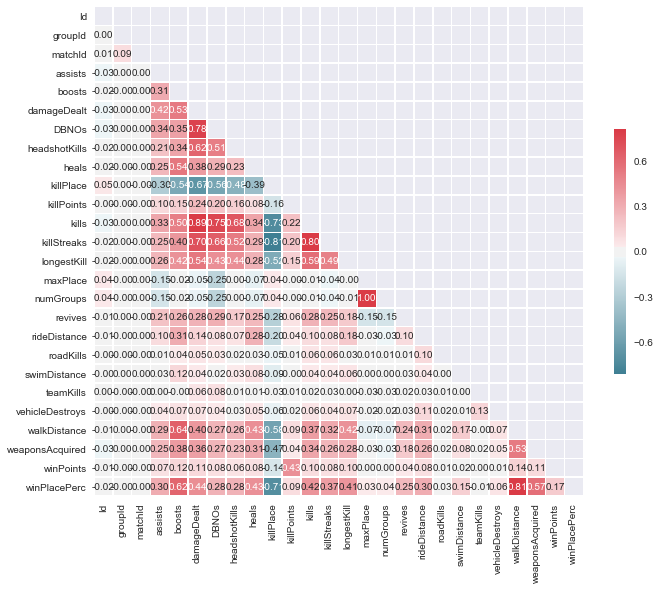

In [11]:
# spearman correlation is very slow
plt.figure(figsize=(30,20))
traindDataCorr= getCorrelationMatrix(trainingData, method="pearson")

# top correlations with win placement

In [12]:
traindDataCorr["winPlacePerc"].sort_values(ascending=False)

winPlacePerc       1.000000
walkDistance       0.811857
boosts             0.618075
weaponsAcquired    0.571521
damageDealt        0.438552
heals              0.427986
kills              0.415350
longestKill        0.405800
killStreaks        0.372546
assists            0.304642
rideDistance       0.301220
DBNOs              0.279475
headshotKills      0.278705
revives            0.251399
winPoints          0.170407
swimDistance       0.154889
killPoints         0.090293
vehicleDestroys    0.057700
numGroups          0.035831
maxPlace           0.034235
roadKills          0.028879
matchId            0.000423
groupId           -0.000239
teamKills         -0.006122
Id                -0.018157
killPlace         -0.708314
Name: winPlacePerc, dtype: float64

In [13]:
trainingData

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,...,1,591.3,0,0.0000,0,0,782.400,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,...,0,0.0,0,0.0000,0,0,119.600,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,...,1,0.0,0,0.0000,0,0,3248.000,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,...,0,0.0,0,0.0000,0,0,21.490,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,...,0,0.0,0,0.0000,0,0,640.800,4,1475,0.5217
5,5,2200824,5,0,2,128.10,0,0,0,25,...,0,2221.0,0,0.0000,0,0,1016.000,4,1500,0.9368
6,6,2568717,6,1,0,130.30,0,0,0,28,...,0,721.7,0,0.0000,0,0,280.100,3,1495,0.3721
7,7,2612473,7,1,1,661.80,2,3,2,3,...,0,0.0,0,0.0000,0,0,2617.000,4,1479,1.0000
8,8,2656377,8,0,3,94.72,0,0,5,50,...,0,2963.0,0,28.9000,0,0,3139.000,5,1528,0.7037
9,9,2700597,9,0,0,137.60,0,0,0,81,...,0,0.0,0,0.0000,0,0,238.700,3,1500,0.0417


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015F126390F0>]], dtype=object)

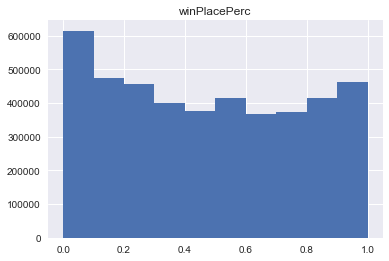

In [14]:
(
    trainingData
    .loc[:, ["winPlacePerc"]]
    .hist()
)

In [15]:
(
    trainingData
    .loc[:, ["winPlacePerc"]]
    .describe()
)

,winPlacePerc
count,4.357336e+06
mean,4.718663e-01
std,3.079147e-01
min,0.000000e+00
25%,1.979000e-01
50%,4.583000e-01
75%,7.407000e-01
max,1.000000e+00


# Fit a crappy baseline linear model

In [142]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer

In [21]:
def splitData(X, y, trainFraction = 0.6, shuffle=True):
    
    splitData = train_test_split(X, y, train_size = trainFraction, shuffle=shuffle)
    
    return splitData

In [23]:
# split into train and test
X_train, X_test, y_train, y_test = splitData(
    trainingData.drop("winPlacePerc", axis="columns"), 
    trainingData["winPlacePerc"],
    trainFraction = 0.6,
    shuffle= True
)

C:\Users\Ulric\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [31]:
X_train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'],
      dtype='object')

In [30]:
trainingData.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [81]:
from scipy.stats.distributions import uniform

In [97]:
Ridge?

In [143]:
def createModelPipeline(metricsScorer = None):

      
#     selectedFeatures = ['assists', "kills"]
    
    paramDistributions = {
        "alpha": uniform(0.0, 1.0)
    }
    
    staticParams =  {
        "fit_intercept": True,
        "normalize": False, 
        "random_state": None, 
        "solver": 'auto', 
        "tol": 0.001,    
    }
    
    # normalize features
    modelPipeline = make_pipeline(
#         FunctionTransformer(lambda X: X[:, selectedFeatures]),
        StandardScaler(with_mean=True, with_std=True),
        RandomizedSearchCV(
            estimator = Ridge(**staticParams),
            param_distributions = paramDistributions,
             n_iter=3,
            scoring = metricsScorer
        ),
       
    )
    
    
    return modelPipeline

In [147]:
pipeline = createModelPipeline(
    metricsScorer =make_scorer(score_func=mean_absolute_error, greater_is_better=False)
)

In [148]:
pipeline

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomizedsearchcv', RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=...
          scoring=make_scorer(mean_absolute_error, greater_is_better=False),
          verbose=0))])

In [174]:
selectedFeatures = [
    'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints'
    
]

# Fit baseline model

In [175]:
def fitModel(pipeline, selectedFeatures, X, y):
    
    fittedModel = pipeline.fit(
    X.loc[:, selectedFeatures], 
    y)

    cvResults = fittedModel.named_steps.get('randomizedsearchcv')
    
    print("best estimator")
    print(cvResults.best_estimator_)
    
    print("best score")
    print(cvResults.best_score_)
    
    return fittedModel

In [176]:
fittedModel = fitModel(pipeline=pipeline, selectedFeatures=selectedFeatures, X=X_train, y =y_train)

best estimator
Ridge(alpha=0.096029202835308025, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
best score
-0.10055263748


In [150]:
fittedModel = fitModel(pipeline=pipeline, selectedFeatures=selectedFeatures, X=X_train, y =y_train)

best estimator
Ridge(alpha=0.27470787898310167, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)
best score
-0.14321226172


In [177]:
temp = fittedModel.named_steps.get("randomizedsearchcv")

In [178]:
temp.scorer_

make_scorer(mean_absolute_error, greater_is_better=False)

In [179]:
test_preds = fittedModel.predict(X_test.loc[:, selectedFeatures])

In [180]:
test_preds

array([ 0.77917286,  0.1379168 ,  0.03518507, ...,  0.13032306,
        0.78256461,  0.08402249])

In [172]:
test_preds - (1.0-test_preds)

array([ 0.16278114, -0.57282994, -0.8912087 , ..., -0.59888083,
        0.504731  , -0.76647162])

In [154]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [183]:
def evalModel(y_true, y_pred, metric_function):
    
    result = metric_function(y_true, y_pred)
    
    plt.figure()
    plt.scatter(y_pred, y_true, alpha = 0.01)
    
    return result

0.10051997057964915

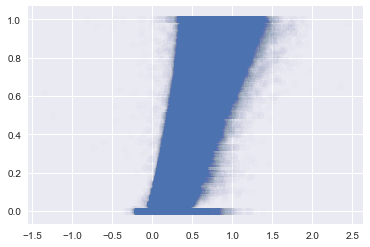

In [184]:
evalModel(y_test, test_preds, mean_absolute_error)

# XGboost

In [187]:
import xgboost as xgb

ImportError: No module named 'xgboost'